<a href="https://colab.research.google.com/github/VictorUceda/TrackNet-Padel/blob/main/Analisis_hits_padel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/')
!git clone https://github.com/VictorUceda/TrackNet-Padel.git

os.chdir('/content/TrackNet-Padel/')
!git pull

Cloning into 'TrackNet-Padel'...
remote: Enumerating objects: 1195, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 1195 (delta 56), reused 55 (delta 21), pack-reused 1073
Receiving objects: 100% (1195/1195), 1.08 GiB | 27.17 MiB/s, done.
Resolving deltas: 100% (523/523), done.
Checking out files: 100% (328/328), done.
Already up to date.


In [3]:
input_name =  'PremierRoma_Final_2_10'#'Final_PremierQatar_2_21'#'punto_qatar'# 
path_in = '/content/gdrive/MyDrive/PadelMatchs/'
path = '/content/gdrive/MyDrive/PadelData/'
path_res = '/content/gdrive/MyDrive/PadelRes/'
path_git = '/content/TrackNet-Padel/raw_data/points/cleanVal/'
point_n = 2
use_yolo = True

#Inicialización de datos

In [33]:
import pickle
import pandas as pd
from utils import load_info

players_file = path_in+input_name+"_"+str(point_n)+'.playersbox'
if use_yolo:
  players_file += '.yolo'
with open(players_file, "rb") as fp:  
  person_results = pickle.load(fp)

if not use_yolo:
  for ind, val in person_results.copy().items():
    person_results[ind] = [p['bbox'] for p in val]
print(person_results[10])
#print([p['bbox'] for p in person_results[10]])

#import pickle
#with open(path+input_name+'.ballpos', "rb") as fp:  
#  ball_pos = pickle.load(fp)

df_points = pd.read_csv(path_in+input_name+'.points.csv', sep=';')
segments_points = [[row['ini'], row['fin']] for _, row in df_points.iterrows()]
print("segmento a analizar -> "+str(segments_points[point_n]))

info = load_info(path_git+input_name+"_"+str(point_n)+".csv")

#[(i, ball_pos[i]) for i in range(segments_points[point_n][0],segments_points[point_n][1]) if i in ball_pos.keys()]

[array([8.53659302e+02, 4.52167969e+02, 9.62942749e+02, 5.95145020e+02,
       9.24296737e-01]), array([356.11105347, 421.22854614, 442.53366089, 563.05249023,
         0.91816682]), array([559.28991699, 198.27680969, 603.59204102, 308.24453735,
         0.89282441]), array([636.68621826, 171.62161255, 697.2946167 , 255.46221924,
         0.84020841]), array([5.39543335e+02, 8.00300751e+01, 5.64210449e+02, 1.15013092e+02,
       4.23203051e-01]), array([7.35302124e+02, 6.00335617e+01, 7.58862549e+02, 1.15734222e+02,
       2.67495155e-01]), array([7.08498230e+02, 6.00679169e+01, 7.32058167e+02, 8.67027435e+01,
       2.65058756e-01])]
segmento a analizar -> [1155, 1320]


In [34]:
import numpy as np
import matplotlib.path as mpltPath
import cv2

video_path = path_in+input_name+"_"+str(point_n)+'.mp4'
cap = cv2.VideoCapture(video_path)

vid_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
r_x, r_y = vid_size[0]/1280, vid_size[1]/720
print(r_x)
print(r_y)
pista_aristas = np.array([[390,213], [890,213],[1114,622],[162,618]])
linea_saque_fondo = 250*r_y
linea_saque_cerca = 518*r_y
red_bajo = 350*r_y
red_alto = 300*r_y

pista_aristas = np.array([np.array([int(p[0]*r_x),int(p[1]*r_y)]) for p in pista_aristas])

pista = mpltPath.Path(pista_aristas)

ball_pos = {}
for f, pos in info.items():
  ball_pos[f]=[pos['x']*vid_size[0], pos['y']*vid_size[1]]


def calc_ball_speed(ball_pos):
  last_f, last_pos = 0,[]
  for f, pos in ball_pos.items():
    if f-last_f < 5 and last_pos != [] and pos[0]>=0:
      vel = [pos[0] - last_pos[0], pos[1] - last_pos[1]]
      vel = [v/ (f-last_f) for v in vel]
      pos.append(vel)
    if pos[0]>0:
      last_f, last_pos = f, pos
calc_ball_speed(ball_pos)
ball_pos[10]

1.0
1.0


[728.3199999999999, 265.68, [24.319999999999936, 13.680000000000035]]

#Analisis

### Aux functions

In [6]:
import numpy as np
import cv2



def plot_court(img):
  pista_campo_fondo = np.array([[390,213], [890,213], [965,350], [315,350]])
  pista_campo_cerca = np.array([[315,350], [965,350],[1114,622],[162,618]])
  r_x, r_y = img.shape[1]/1280, img.shape[0]/720
  pista_campo_fondo = np.array([np.array([int(p[0]*r_x),int(p[1]*r_y)]) for p in pista_campo_fondo])
  pista_campo_cerca = np.array([np.array([int(p[0]*r_x),int(p[1]*r_y)]) for p in pista_campo_cerca])
  vis_img = cv2.polylines(img, np.int32([pista_campo_fondo]), True, (255,150,255),3)
  vis_img = cv2.polylines(img, np.int32([pista_campo_cerca]), True, (255,70,255),3)
  return vis_img

#image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img.png')
#cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img_court.png', plot_court(image))

In [7]:
import numpy as np
import matplotlib.path as mpltPath
import math
import random
def rectangle_dist(bbox1, bbox2):
  if len(bbox1)>=4 and len(bbox2)>=4:
    c1 = [(bbox1[0]+bbox1[2])/2, (bbox1[1]+bbox1[3])/2]
    c2 = [(bbox2[0]+bbox2[2])/2, (bbox2[1]+bbox2[3])/2]
    d =  math.sqrt( (bbox2[0] - bbox1[0])**2 + (bbox2[1] - bbox1[1])**2 )
    d += math.sqrt( (bbox2[0] - bbox1[0])**2 + (bbox2[3] - bbox1[3])**2 )
    d += math.sqrt( (bbox2[2] - bbox1[2])**2 + (bbox2[1] - bbox1[1])**2 )
    d += math.sqrt( (bbox2[2] - bbox1[2])**2 + (bbox2[3] - bbox1[3])**2 )
    if d == 0:
      return d+random.random()/100
    return d/4
  elif len(bbox1)>=2 and len(bbox2)>=2:
    c1, c2 = bbox1, bbox2
    return math.sqrt( (c2[0] - c1[0])**2 + (c2[1] - c1[1])**2 )
  else:
    return None


#pista_c0 = mpltPath.Path(pista_campo_cerca)

def persons_in_court(persons, pista, debug=-1):
  players=[]
  for i in range(len(persons)):
    p = persons[i]
    if i == debug:
      print(pista)
      print(pista.contains_points([[p[2],p[3]]]))
      print(pista.contains_points([[p[0],p[3]]]))
      print(p)
    if pista.contains_points([[p[2],p[3]]]) or \
        pista.contains_points([[p[0],p[3]]]):
      players.append(i)
      if len(players) == 4:
        break
  return [persons[i] for i in range(len(persons)) if i in players], \
          [persons[i] for i in range(len(persons)) if i not in players]

#players_box = []
#for f in person_results:
#  players_box.append(persons_in_court(f, pista))
#print(players_box)
  #print(p['bbox'])

#cv2.putText(img, str(i), (p['bbox'][0],p['bbox'][3]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (10, 255, 0), 1, cv2.LINE_AA)
#players_box
#cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img_court.png', img)
#path.contains_points([(100,100)])

### Track jugador cercano

In [35]:

import copy
def identify_players(persons, last_players, pista, debug = False):
  distances = []
  if len(persons) == 0:
    return []
  
  p_in_court, p_not_in_court = persons_in_court(persons, pista)
  if debug: print("--->debug call identify_players")
  if debug: print(len(last_players))
  if len(last_players) == 0:
    if debug: print(str(len(p_in_court)) + " players in court")
    return [np.append(p_in_court[i], int(i)) for i in range(len(p_in_court))]
  
  players = []
  
  if len(p_in_court) > 0: #Asignar los jugadores dentro de la pista con su posición previa más cercana
    candidates = p_in_court
    distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    while distances_m.size >0 and len(players) < 4 and distances_m.min() < 30:
      if debug: print(distances_m)
      distances_min = distances_m.min()
      if debug: print(distances_min)
      ij_min = np.where(distances_m == distances_min)
      
      (i_min,j_min) = tuple([i.item() for i in ij_min])

      pl = candidates[j_min] 
      pl = np.append(pl, last_players[i_min][5])
      pl = np.append(pl, distances_min)
      players.append(pl)
      if debug: print("player "+str(pl[5])+" localizado dentro de pista")
      if debug:print(last_players[i_min])
      if debug:print(candidates[j_min])
      #if debug:print((i_min,j_min))
      #distances_m = np.delete(distances_m, i_min, 0)
      #distances_m = np.delete(distances_m, j_min, 1)
      del last_players[i_min]
      del candidates[j_min]
      distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    if len(last_players) == 0:
      while len(p_in_court) > 0 and len(players) < 4: #nuevos jugadores
        new_id = [i for i in range(4) if i not in [p[5] for p in players]][0]
        pl = np.append(p_in_court[0], new_id)
        pl = np.append(pl, -1)
        players.append(pl)
        if debug: print("nuevo player "+str(pl[5])+" detectado")
        del p_in_court[0]
  
  candidates = p_not_in_court
  if len(candidates) > 0 and len(last_players) > 0 and len(players) < 4: #buscar jugadores fuera de pista
    distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    while distances_m.size >0 and len(players) < 4 and distances_m.min() < 30:
      distances_min = distances_m.min()
      ij_min = np.where(distances_m == distances_min)
      
      #print(distances_min)
      i_min, j_min = tuple([i.item() for i in ij_min])

      pl = candidates[j_min] 
      pl = np.append(pl, last_players[i_min][5])
      pl = np.append(pl, distances_min)
      players.append(pl)
      if debug: print("player "+str(pl[5])+" localizado dentro de pista")
      if debug:print(last_players[i_min])
      if debug:print(candidates[j_min])
      #if debug:print((i_min,j_min))
      #distances_m = np.delete(distances_m, i_min, 0)
      #distances_m = np.delete(distances_m, j_min, 1)
      del last_players[i_min]
      del candidates[j_min]
      distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    
  return players

ini_frame, end_frame = 0, max(person_results.keys())
players_box = [identify_players(copy.deepcopy(person_results[ini_frame]), [], pista, True)]
print(players_box)
for i in range(ini_frame, end_frame):
  players_box.append(identify_players(copy.deepcopy(person_results[i]), copy.deepcopy(players_box[-1]) if len(players_box)>0 else [], pista, debug=False))
#  print("players frame "+str(i)+":")
#  print(players_box[i])
#print(players_box[1351])
#print(players_box[1352])
#print(max([max([p[-1] for p in per]) for per in players_box if per != []]))

--->debug call identify_players
0
4 players in court
[[array([356.13433838, 420.3399353 , 443.46496582, 562.3092041 ,
         0.91375023,   0.        ]), array([8.47163818e+02, 4.25306061e+02, 9.40840332e+02, 5.83253540e+02,
       9.13426399e-01, 1.00000000e+00]), array([555.36248779, 198.80020142, 597.39349365, 304.17715454,
         0.86156404,   2.        ]), array([598.48406982, 159.16790771, 666.28717041, 248.65319824,
         0.81601423,   3.        ])]]


### Procesado de pista y detector de plano central

In [9]:
import math
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow # for image display

import matplotlib.pylab as plt

def avg(lst):
    return sum(lst)/len(lst)

def group_similar_lines(lines, v_h = 0):
  res_lines = []
  for l in lines:
    dist = [[abs((l[0+v_h]+l[2+v_h])/2 - avg([(s[0+v_h]+s[2+v_h])/2 for s in res_lines[i]])) , i] for i in range(len(res_lines))]
    if dist != []:
      dist.sort(key=lambda a: a[0])
      if dist[0][0] < 5:
        res_lines[dist[0][1]].append(l)
      else:
        res_lines.append([l])
    else:
      res_lines.append([l])
  res = []
  for g in res_lines:
    x = int(round(avg([(l[0+v_h]+l[2+v_h])/2 for l in g]), 0))
    width = max([max(l[0+v_h],l[2+v_h]) for l in g]) - min([min(l[0+v_h],l[2+v_h]) for l in g])   
    y_min = int(round(min([min([l[1-v_h],l[3-v_h]]) for l in g]), 0))
    y_max = int(round(max([max([l[1-v_h],l[3-v_h]]) for l in g]), 0))
    if v_h==0: #vertical line
      res.append([x, y_min, x, y_max, width])
    else: #horizontal line
      res.append([y_min, x, y_max, x, width])
  return res

def line_intersection_vh(line_v, line_h):
    if line_v[0] <= max(line_h[0], line_h[2]) and \
        line_v[0] >= min(line_h[0], line_h[2]) and \
        line_h[1] <= max(line_v[1], line_v[3]) and \
        line_h[1] >= min(line_v[1], line_v[3]):
      return [line_v[0], line_h[1]]
    return None

def is_central_camera(img, search_intersection=False, plot=False):
  r_x, r_y = img.shape[1]/1280, img.shape[0]/720
  if False:
    t_points = [[int(637*r_x), int(251*r_y)], [int(637*r_x), int(518*r_y)], int(25*r_y)]
  else:
    t_points = [[int(635*r_x), int(245*r_y)], [int(640*r_x), int(521*r_y)], int(25*r_y)]
  thresh, img_bin = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
  scale = 0.4
  img_bin = cv2.resize(img_bin, (int(img.shape[1]*scale), int(img.shape[0]*scale)), interpolation = cv2.INTER_AREA) # resize image
  dst = cv2.Canny(img_bin, 50, 200, None, 3)
   
  # Copy edges to the images that will display the results in BGR
  #cdst = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  cdst = np.copy(img)
  #cv2_imshow( cdstP)
    
  #lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
    
  #if lines is not None:
  #  for i in range(0, len(lines)):
  #    rho = lines[i][0][0]
  #    theta = lines[i][0][1]
  #    a = math.cos(theta)
  #    b = math.sin(theta)
  #    x0 = a * rho
  #    y0 = b * rho
  #    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
  #    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
  #    cv.line(cdst, pt1, pt2, (0,255,0), 3, cv.LINE_AA)

  linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)
  instersection = []
  if linesP is not None:
    linesP = [[e/scale for e in line] for line in linesP]
    h_lines = [l[0] for l in linesP if abs(l[0][1]-l[0][3])<3]
    v_lines = [l[0] for l in linesP if abs(l[0][0]-l[0][2])<45]
    
    v_lines = group_similar_lines(v_lines)
    h_lines = group_similar_lines(h_lines, 1)
    
    if plot:
      for i in range(0, len(v_lines)):
        #print(linesP[i])
        l = v_lines[i]
        cdst = cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,200,100), 3, cv2.LINE_AA)
        #cv2.putText(img, str(i), (l[2], l[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,100), 2, cv2.LINE_AA)
      for i in range(0, len(h_lines)):
        #print(linesP[i])
        l = h_lines[i]
        cdst = cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv2.LINE_AA)
        #cv2.putText(img, str(i), (l[2], l[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
        #print(v_lines)
      #cdst = cv2.line(cdst, (t_points[0][0], t_points[0][1]-200), (t_points[0][0], t_points[0][1]+200), (255,0,0), 3, cv2.LINE_AA)
      cv2_imshow(cdst)
    if search_intersection:
      for v in v_lines:
        for h in h_lines:
          instersection.append(line_intersection_vh(v, h))
      instersection = [i for i in instersection if i]
      if instersection != []:
        t_point_detected = 0
        for p in instersection:
          cv2.circle(img, (int(p[0]), int(p[1])), 8, (0,0,255), -1)
          if rectangle_dist(p, t_points[0]) < t_points[2] or \
              rectangle_dist(p, t_points[1]) < t_points[2]:
              t_point_detected +=1
        #print(t_point_detected)
        cv2_imshow(img)
        if t_point_detected >= 2:
          return img, True
    else: # search lines
      found_v, found_h = False, False
      for v in v_lines:
        if v[0] < t_points[0][0]+ t_points[2] and \
          v[0] > t_points[0][0] - t_points[2] and \
          abs(v[3]-v[1]) > 100:
          found_v = True
          break
      for h in h_lines:
        if ((h[1] < t_points[0][1]+ t_points[2] and \
          h[1] > t_points[0][1] - t_points[2]) or \
          (h[1] < t_points[1][1]+ t_points[2] and \
          h[1] > t_points[1][1] - t_points[2])) and \
          abs(h[2]-h[0]) > 100:
          found_h = True
          break
      if found_v and found_h:
        if plot: print('is central')
        return img, True
  if plot: print(str(found_v)+' - '+str(found_h))
  return cdst, False


### Dist ball2players

In [36]:
import math
def sqr (x):
  return x * x


def dist2 (v, w):
  return sqr(v[0] - w[0]) + sqr(v[1] - w[1])

def distToSegmentSquared (p, v, w):
  l2 = dist2(v, w)
  if (l2 == 0): return dist2(p, v)
  t = ((p[0] - v[0]) * (w[0] - v[0]) + (p[1] - v[1]) * (w[1] - v[1])) / l2
  t = max(0, min(1, t))
  return dist2(p, [ v[0] + t * (w[0] - v[0]), v[1] + t * (w[1] - v[1]) ])


def distToSegment (p, v, w):
  return math.sqrt(distToSegmentSquared(p, v, w));

print(players_box[2])
for n in ball_pos.keys():
  if n < len(players_box):
    for i in range(len(players_box[n])):
      p = players_box[n][i]
      d = min([ distToSegment(ball_pos[n], [p[0],p[1]], [p[0],p[3]]),
             distToSegment(ball_pos[n], [p[0],p[1]], [p[2],p[1]]),
             distToSegment(ball_pos[n], [p[2],p[1]], [p[2],p[3]]),
             distToSegment(ball_pos[n], [p[0],p[3]], [p[2],p[3]])])
      players_box[n][i] = np.append(p, d)

players_box[2] 

[array([5.55464355e+02, 1.98602341e+02, 5.97522095e+02, 3.05010162e+02,
       8.61027837e-01, 2.00000000e+00, 5.35153698e-01]), array([356.52682495, 420.73843384, 442.243927  , 562.76593018,
         0.91829497,   0.        ,   0.93740238]), array([8.50378601e+02, 4.24319611e+02, 9.41563538e+02, 5.81615845e+02,
       9.22265112e-01, 1.00000000e+00, 2.49601045e+00]), array([600.65460205, 162.03605652, 672.65618896, 247.21014404,
         0.8381992 ,   3.        ,   4.92970315])]


[array([5.55464355e+02, 1.98602341e+02, 5.97522095e+02, 3.05010162e+02,
        8.61027837e-01, 2.00000000e+00, 5.35153698e-01, 1.04209473e+00]),
 array([356.52682495, 420.73843384, 442.243927  , 562.76593018,
          0.91829497,   0.        ,   0.93740238, 266.21120744]),
 array([8.50378601e+02, 4.24319611e+02, 9.41563538e+02, 5.81615845e+02,
        9.22265112e-01, 1.00000000e+00, 2.49601045e+00, 3.36319850e+02]),
 array([600.65460205, 162.03605652, 672.65618896, 247.21014404,
          0.8381992 ,   3.        ,   4.92970315,   4.17460205])]

## Analisis golpes

### Analisis punto_qatar

False
[6, 11, 21, 23, 32, 37, 42, 47, 71, 95, 99, 101, 104, 114, 130, 140, 145, 150, 171, 181, 186, 191, 197, 207, 218, 222, 231, 233, 242, 251, 268, 278, 294, 343, 347, 351, 378, 391, 396, 402, 407, 438, 443, 449, 464, 479, 496, 507, 511, 516, 527, 532, 537, 545, 550, 555, 588, 597, 603, 609, 614, 630, 636, 641, 659, 664, 668, 680, 688, 700, 705, 710, 716, 735, 740, 746, 750, 752, 757, 763, 769, 773, 775, 777, 801, 805, 811, 814, 816, 821, 826, 851, 856, 861, 865, 871, 881, 886, 891, 897, 902, 907, 929, 935, 939, 944, 954, 956, 959, 1000, 1022, 1026, 1031, 1035, 1038, 1041, 1043, 1047, 1052, 1057, 1061, 1077, 1085, 1091, 1106, 1138, 1145, 1151, 1157, 1168, 1186, 1191, 1196, 1218, 1224, 1230, 1236, 1239, 1245, 1267, 1276, 1283, 1289, 1295, 1300, 1313, 1323, 1328, 1340, 1343, 1348, 1353, 1363, 1368, 1421, 1435, 1444, 1451, 1456, 1460, 1472, 1478, 1489, 1496, 1501, 1507, 1514, 1519, 1533, 1538, 1543, 1563, 1566, 1579, 1603, 1608, 1612, 1619, 1633, 1635, 1639, 1655, 1679, 1683, 1688, 1693

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


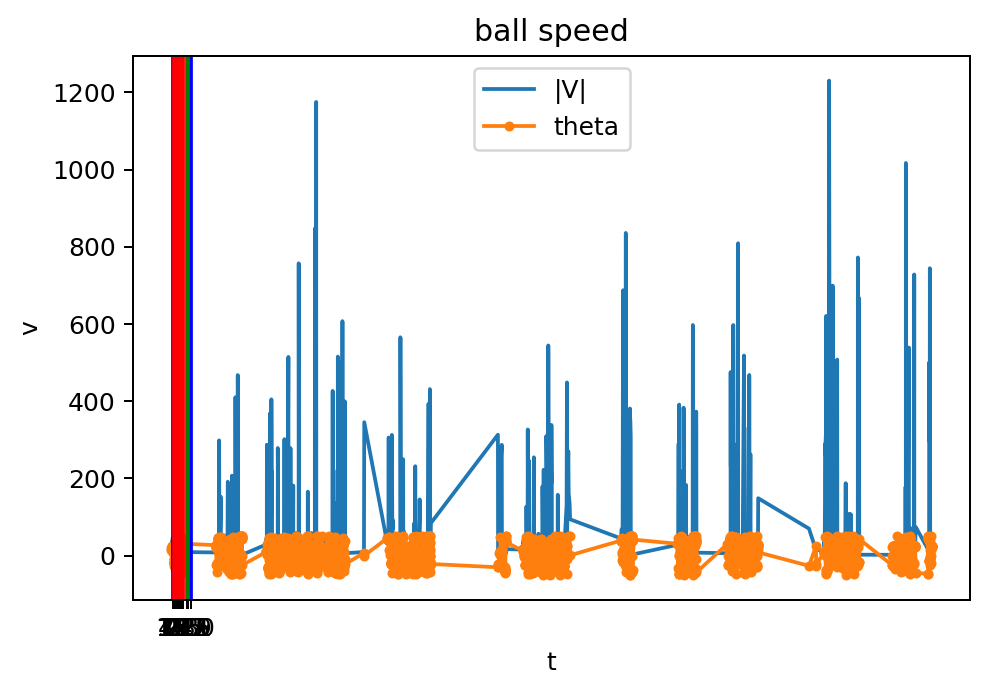

In [ ]:
import cmath
hits = [46, 73, 94, 125, 147, 171, 215]
wall = [231]
bounce = [32, 115, 229, 280]
ball_t = [int(t) for t in ball_pos.keys() if len(ball_pos[t][0])>2]
ball_v_x = [ball_pos[t][0][2][0] for t in ball_t if len(ball_pos[t][0])>2]
ball_v_y = [ball_pos[t][0][2][1] for t in ball_t if len(ball_pos[t][0])>2]
ball_v = [math.sqrt(x*x+y*y) for x,y in zip(ball_v_x, ball_v_y)]
ball_o = [cmath.polar(complex(x,y))[1]*100/(2*math.pi) for x,y in zip(ball_v_x, ball_v_y)]

to_delete = []

for i in range(1,len(ball_t)-1):
  if i==43: print(ball_v[i] < ball_v[i-1]-8 and ball_v[i] < ball_v[i+1]-8)
  if ball_v[i] < ball_v[i-1]-8 and ball_v[i] < ball_v[i+1]-8:
    to_delete.append(i)
print(to_delete)

ball_t = [ball_t[i] for i in range(len(ball_t)) if i not in to_delete]
ball_v_x = [ball_v_x[i] for i in range(len(ball_v_x)) if i not in to_delete]
ball_v_y = [ball_v_y[i] for i in range(len(ball_v_y)) if i not in to_delete]
ball_v = [ball_v[i] for i in range(len(ball_v)) if i not in to_delete]
ball_o = [ball_o[i] for i in range(len(ball_o)) if i not in to_delete]


print(list(zip(range(len(ball_v)), ball_v)))


import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180

radians = True
if radians:
  plt.plot(ball_t, ball_v, label="|V|")
  plt.plot(ball_t, ball_o, label="theta", marker='.')
else:
  plt.plot(ball_t, ball_v_x, label="V_x", marker='.')
  plt.plot(ball_t, ball_v_y, label="V_y", marker='x')
plt.xticks(wall+bounce+hits)
for b in bounce:
  plt.axvline(x=b, color='b')
for h in hits:
  plt.axvline(x=h, color='r')
for w in wall:
  plt.axvline(x=w, color='g')

plt.plot()

plt.xlabel("t")
plt.ylabel("v")
plt.title("ball speed")
plt.legend()
plt.axes().xaxis.grid(True, which='minor')
plt.show()

### Analisis Qatar_trim

[26, 129, 130, 131, 136, 137, 138]
[(0, 0.0), (1, 1.2799999999999727), (2, 0.7199999999999989), (3, 18.130901797759517), (4, 19.894119734232998), (5, 20.505608988762123), (6, 19.592161697985304), (7, 23.153194164088916), (8, 16.96377316518929), (9, 27.903490821042407), (10, 25.702918122267747), (11, 24.000000000000025), (12, 16.29252589379555), (13, 34.63251651266488), (14, 27.78661548299826), (15, 21.05444371148289), (16, 38.400000000000034), (17, 31.171782111390332), (18, 34.927032510649944), (19, 30.292124389022355), (20, 39.76772560758293), (21, 29.76010752668739), (22, 20.480000000000018), (23, 22.184679398179266), (24, 14.954865429016676), (25, 40.459757784741996), (26, 40.27934458255259), (27, 44.02791841547808), (28, 43.63580181456514), (29, 34.938757848555426), (30, 29.237674326115584), (31, 30.256609195347757), (32, 32.35018392528858), (33, 28.37384711314283), (34, 23.981326068422483), (35, 27.169865660323072), (36, 20.769362050866974), (37, 21.68516543630696), (38, 15.212626

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


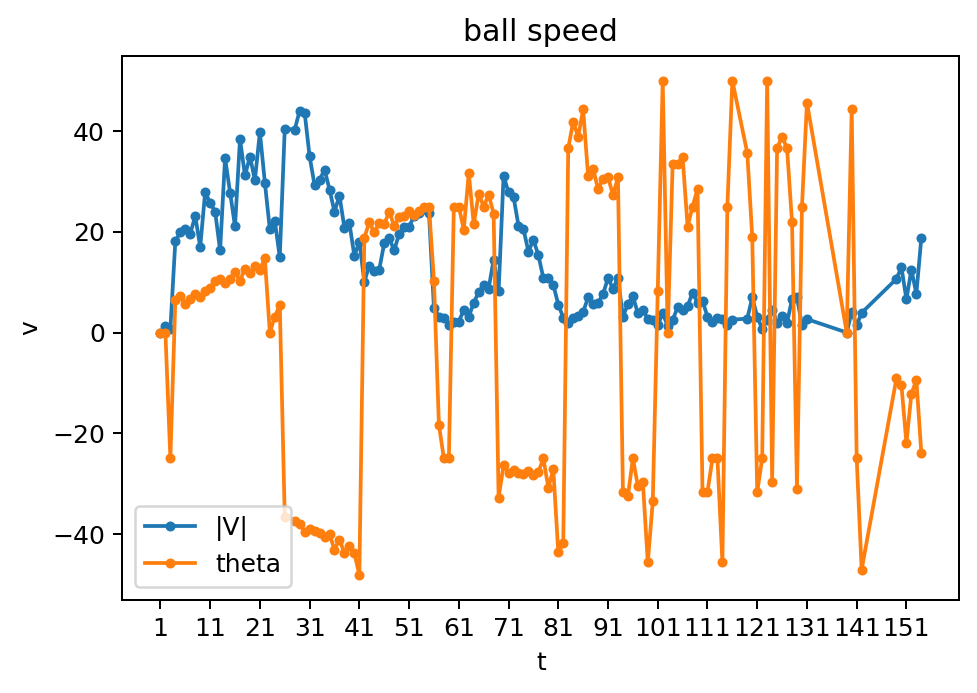

In [11]:
import cmath
hits = []
wall = []
bounce = []

ball_t = [int(t) for t in ball_pos.keys() if len(ball_pos[t])>2]
ball_v_x = [ball_pos[t][2][0] for t in ball_t if len(ball_pos[t])>2]
ball_v_y = [ball_pos[t][2][1] for t in ball_t if len(ball_pos[t])>2]
ball_v = [math.sqrt(x*x+y*y) for x,y in zip(ball_v_x, ball_v_y)]
ball_o = [cmath.polar(complex(x,y))[1]*100/(2*math.pi) for x,y in zip(ball_v_x, ball_v_y)]

to_delete = []

for i in range(1,len(ball_t)-1):
  if (ball_v[i] < ball_v[i-1]-15 and ball_v[i] < ball_v[i+1]-15) or ball_v[i]>50:
    to_delete.append(i)
print(to_delete)

ball_t = [ball_t[i] for i in range(len(ball_t)) if i not in to_delete]
ball_v_x = [ball_v_x[i] for i in range(len(ball_v_x)) if i not in to_delete]
ball_v_y = [ball_v_y[i] for i in range(len(ball_v_y)) if i not in to_delete]
ball_v = [ball_v[i] for i in range(len(ball_v)) if i not in to_delete]
ball_o = [ball_o[i] for i in range(len(ball_o)) if i not in to_delete]


print(list(zip(range(len(ball_v)), ball_v)))


import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180

radians = True
if radians:
  plt.plot(ball_t, ball_v, label="|V|", marker='.')
  plt.plot(ball_t, ball_o, label="theta", marker='.')
else:
  plt.plot(ball_t, ball_v_x, label="V_x", marker='.')
  plt.plot(ball_t, ball_v_y, label="V_y", marker='x')
plt.xticks(np.arange(min(ball_t), max(ball_t)-1, 10))
for b in bounce:
  plt.axvline(x=b, color='b')
for h in hits:
  plt.axvline(x=h, color='r')
for w in wall:
  plt.axvline(x=w, color='g')

plt.plot()

plt.xlabel("t")
plt.ylabel("v")
plt.title("ball speed")
plt.legend()
plt.axes().xaxis.grid(True, which='minor')
plt.show()

In [ ]:
from DLT import *
# Known 3D coordinates
xyz = [[-875, 0, 9.755], [442, 0, 9.755], [1921, 0, 9.755], [2951, 0.5, 9.755], [-4132, 0.5, 23.618],[-876, 0, 23.618]]
    # Known pixel coordinates
uv = [[76, 706], [702, 706], [1440, 706], [1867, 706], [264, 523], [625, 523]]

nd = 3
P, err = DLTcalib(nd, xyz, uv)
print('Matrix')
print(P)
print('\nError')
print(err)

ModuleNotFoundError: ignored

# Imprimir resultado a video

In [38]:
import cv2
def plot_players(img, players, color = (255,0,0)):
  i = 1
  for p in players:
    img = cv2.rectangle(img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), color , 2)
    if len(p)>5: cv2.putText(img, str(int(p[5])), (int(p[2]),int(p[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 1, cv2.LINE_AA)
    if len(p)>6: cv2.putText(img, str(round(p[6],2)), (int((p[2]+p[0]-6)/2),int(p[1]-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    if len(p)>7: cv2.putText(img, str(round(p[-1],2)), (int(p[0]-100),int(p[3]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    i += 1
  return img

def plot_ball(img, ball):
  center = (int(ball[0]), int(ball[1]))
  img = cv2.circle(img, center, 5, (0,0,255), 2)
  if len(ball)>2:
    speed = (int(ball[0]+ball[2][0]), int(ball[1]+ball[2][1]))
    img = cv2.arrowedLine(img, center, speed, (0,0,200), 2)
  return img

#players_box = [[p['bbox'] for p in per] for per in person_results]

video_path = path_git+input_name+"_"+str(point_n)+'.mp4'
out_video_root = path_res+'vis_'+input_name+"_"+str(point_n)+'.mp4'
print(video_path)
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
ini_frame, end_frame = 0, max(person_results.keys())
print(size, ini_frame)
print(out_video_root)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
videoWriter = cv2.VideoWriter(out_video_root, fourcc, fps, size)
camera_flag = False
cap.set(cv2.CAP_PROP_POS_MSEC,int(ini_frame*1000/30))
i = ini_frame
while (cap.isOpened()):
        flag, img = cap.read()
        
        if not flag or i>=end_frame:
            print("break: "+str(flag)+" "+str(i))
            break
        
        #modify img
        vis_img = img
        if not i%10:
          vis_img, camera_flag = is_central_camera(vis_img)
        if camera_flag:
          cv2.putText(vis_img, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (10, 255, 0), 1, cv2.LINE_AA)
          vis_img = plot_court(vis_img)
          if i-ini_frame < len(players_box):
            vis_img = plot_players(vis_img, players_box[i-ini_frame])
          if i in ball_pos:
            vis_img = plot_ball(vis_img, ball_pos[i])
        else:
          cv2.putText(vis_img, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (153, 0, 0), 1, cv2.LINE_AA)

        #save img
        videoWriter.write(vis_img)
        
        i += 1
cap.release()
videoWriter.release()

/content/TrackNet-Padel/raw_data/points/cleanVal/PremierRoma_Final_2_10_2.mp4
(1280, 720) 0
/content/gdrive/MyDrive/PadelRes/vis_PremierRoma_Final_2_10_2.mp4
break: True 164


In [ ]:
!ffmpeg -y -i {path+'vis_'+input_name+"_"+str(point_n)+'.mp4'} -c:v libx264 -preset slow -crf 20 -c:a aac -b:a 160k -vf format=yuv420p -movflags +faststart {path_res+'H264_'+input_name+"_"+str(point_n)+'.mp4'} 

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

## Debug Frame

In [ ]:
import cv2

def get_frame(N):
  #players_box = [[p['bbox'] for p in per] for per in person_results]

  video_path = path+input_name+'.mp4'
  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  
  ini_frame, end_frame = segments_points[point_n]
  cap.set(cv2.CAP_PROP_POS_MSEC,int(ini_frame*1000/30))
  i = ini_frame
  while (cap.isOpened()):
          flag, img = cap.read()  
          if not flag or i>=end_frame:
              break
          if i==N:
            vis_img = img
            cv2.putText(vis_img, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (10, 255, 0), 1, cv2.LINE_AA)
            vis_img = plot_court(vis_img)
            #if i-ini_frame < len(person_results):
              #p_in_court, p_not_in_court = persons_in_court(person_results[i], pista)
              #vis_img = plot_players(vis_img, p_in_court)
            if i in ball_pos:
              vis_img = plot_ball(vis_img, ball_pos[i][0])
            
            cap.release()
            return vis_img
          i += 1
  cap.release()
  return None

f4499 = get_frame(4499)

Path(array([[ 585.,  319.],
       [1335.,  319.],
       [1671.,  933.],
       [ 243.,  927.]]), None)
[ True]
[ True]
[1.05635486e+03 2.64606903e+02 1.09535632e+03 4.12921600e+02
 8.18458259e-01]


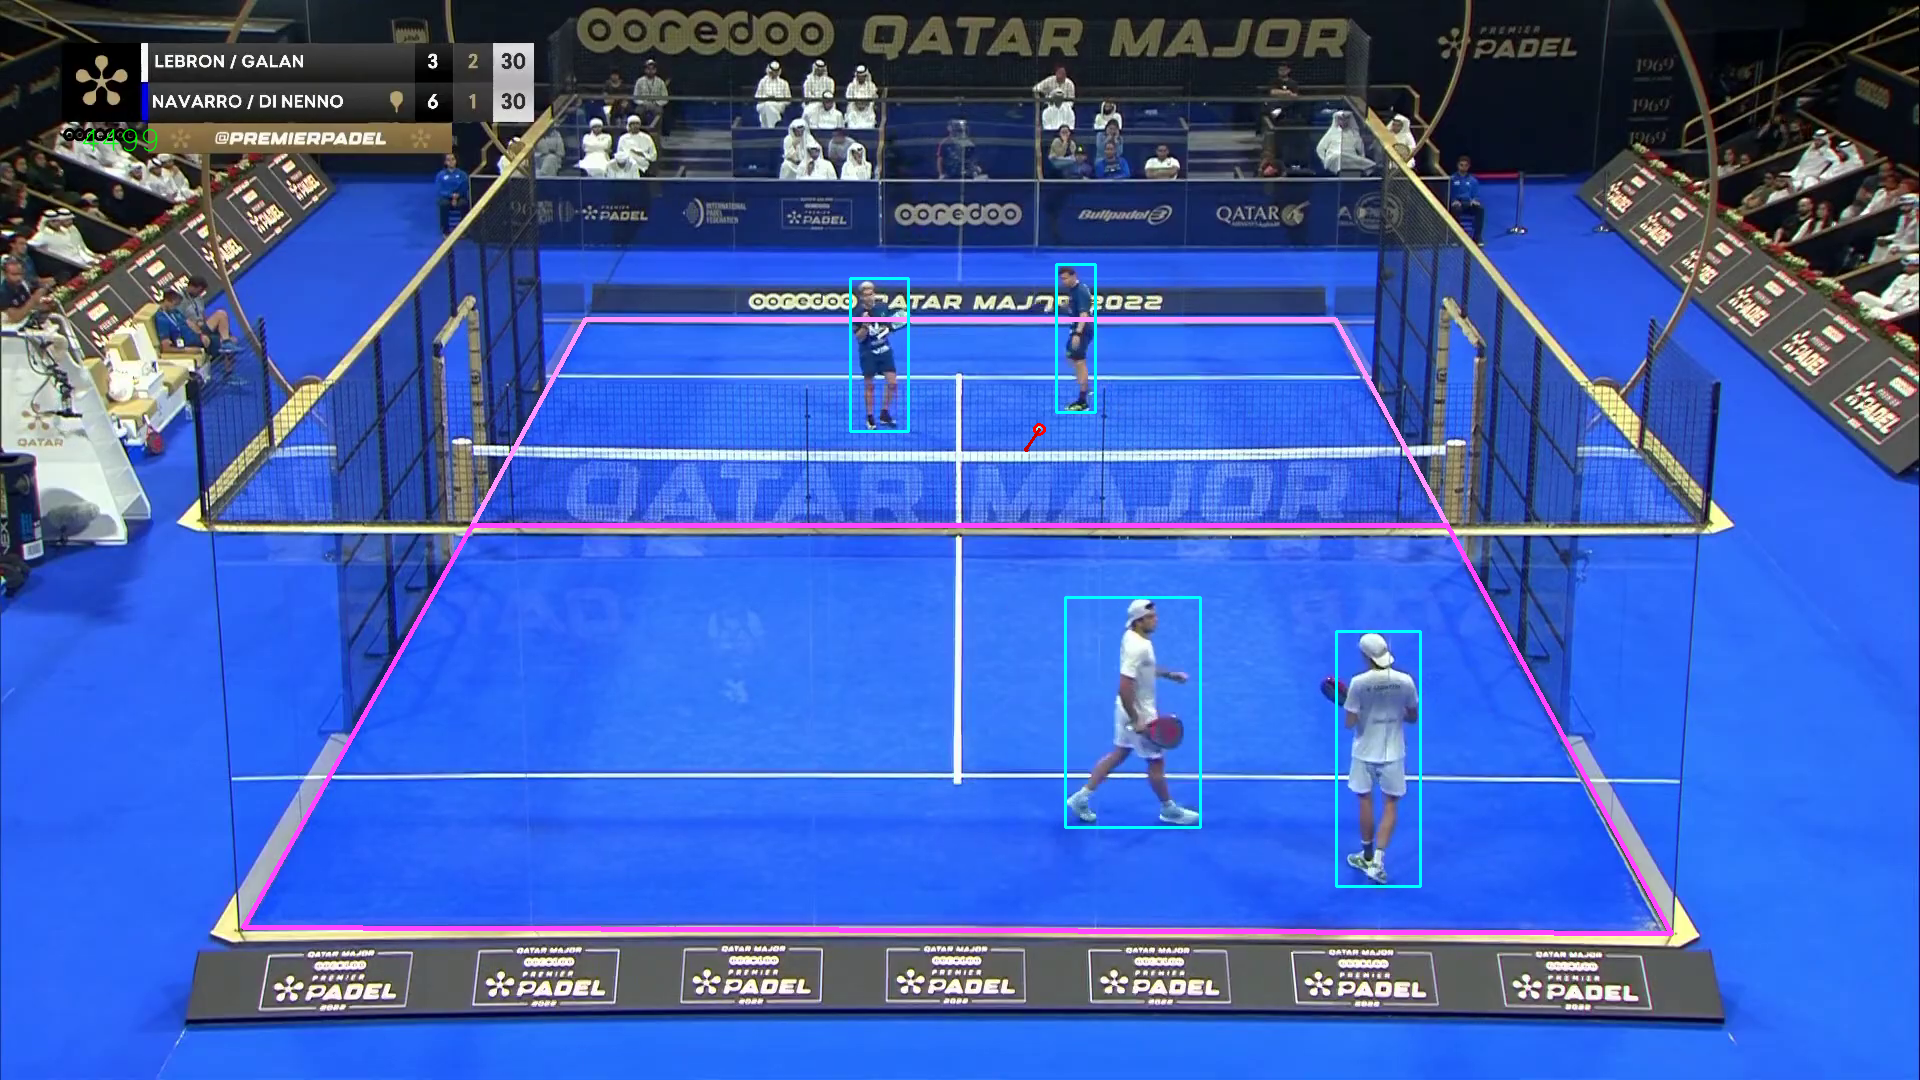

In [ ]:
p_in_court, p_not_in_court = persons_in_court(person_results[4499], pista, debug=3)
vis_f4499 = plot_players(f4499, p_in_court, color=(255,255,0))

cv2_imshow(vis_f4499)

# Analisis Puntos

In [2]:
pip install keras-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 930 kB 30.2 MB/s 
     |████████████████████████████████| 9.5 MB 41.6 MB/s 
     |████████████████████████████████| 603 kB 35.2 MB/s 
     |████████████████████████████████| 50 kB 4.0 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=010a0b68699706533ce729d5d3faf8ded5be51940798b546228bb872c47786e4
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [3]:
#input_name = 'Final_PremiereQatar_2_21'# 'punto_qatar'#
import cv2
vidcap = cv2.VideoCapture(path_in+input_name+'.mp4')
camera_flag = False
in_point = False
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
      #image = image[25:100, 90:370]
      cv2.imwrite(path+str(sec)+" frame.png", image)     # save frame as PNG file
    return hasFrames
getFrame(60*3)

False

In [4]:
#Importing the library
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()



Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [5]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

In [15]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import statistics

model_name = '/content/gdrive/MyDrive/PadelModels/digits_recognition_cnn.h5'
model_digits = tf.keras.models.load_model(model_name)
def identify_digit(frame, debug=False):
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  (T, thresh) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV if gray[0, 0]>127 else cv2.THRESH_BINARY)
  thresh = cv2.resize(thresh, (28, 28), cv2.INTER_AREA)
  thresh = thresh.reshape(1, 28, 28, 1)
  thresh_norm = thresh / 255
  predictions = model_digits.predict([thresh_norm])
  predictions = np.argmax(predictions, axis=1)
  if debug:
    plt.imshow(thresh_norm.reshape((28, 28)), cmap=plt.cm.binary)
    plt.show()
    print(predictions)
  return predictions[0]


def identify_digits(frame, n_digits=1, debug=False):
  x, y, z = frame.shape
  return [identify_digit(frame[:, int(i*y/n_digits):int((i+1)*y/n_digits)], debug)  for i in range(n_digits)]

def set_is_finished(j1, j2):
  return max(j1,j2)==7 or (max(j1,j2)==6 and abs(j1-j2)>=2)

def set_in_tie(j1, j2):
  return (j1==6 and j2==6) #Tie

def parse_marcador(pipeline, frame, parse_players=True, debug=False):
  import numpy as np
  import cv2
  from google.colab.patches import cv2_imshow # for image display
  servicio_box = [[260,32, 270,51, 0], [260,57, 270,76, 0]]
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  ser_color = [np.average(gray[b[1]:b[3], b[0]:b[2]]) for b in servicio_box]
  saque = 0 if ser_color[0]>ser_color[1] else 1
  if debug:  
    print(ser_color)
    [cv2_imshow(gray[b[1]:b[3], b[0]:b[2]])  for b in servicio_box]
  box = [[98,25, 276,53, 0], [98,53, 276,79, 0], [276,28, 303,53, 0], [276,53, 303,79, 0], [303,28, 329,53, 0], [303,53, 329,79, 0], [335,32, 350,50, 1], [335,58, 350,76, 1] ]
  dim = [720, 1280]#[1080, 1920]
  if dim[0]!=frame.shape[0] or dim[1]!=frame.shape[1]:
    r_x, r_y = frame.shape[1]/dim[1], frame.shape[0]/dim[0]
    box = [[int(b[0]*r_x), int(b[1]*r_y), int(b[2]*r_x), int(b[3]*r_y), b[4]] for b in box]
  images = [frame[b[1]:b[3], b[0]:b[2]] for b in box]
  
  res1, res2 = [], []
  if parse_players:
    inv_images = [cv2.bitwise_not(img) for img in images[:2]]
    prediction_groups = pipeline.recognize(images[:2])
    prediction_groups_inv = pipeline.recognize(inv_images)

    if debug:
      for pred, pred_i, img in zip(prediction_groups, prediction_groups_inv, images[:2]):
        for p in pred+pred_i:
          cv2.putText(img, str(p[0]), (int(p[1][3][0]),int(p[1][3][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (10, 255, 0), 1, cv2.LINE_AA)
        cv2_imshow(img)

    #return [[p[0] for p in pred if len(p)>0] for pred in prediction_groups]
    if len(prediction_groups)>1:
      res1.append([p[0] for p in prediction_groups[0]])
      res2.append([p[0] for p in prediction_groups[1]])
#    if len(prediction_groups)>3:
#      res1.append(prediction_groups[2][0][0])
#      res2.append(prediction_groups[3][0][0])
#    if len(prediction_groups)>5:
#      res1.append(prediction_groups[4][0][0])
#      res2.append(prediction_groups[5][0][0])
#    if len(prediction_groups[6])>7:
#      res1.append(prediction_groups[6][0][0])
#      res2.append(prediction_groups[7][0][0])

  res1.append(identify_digits(images[2], debug=debug)[0])
  res2.append(identify_digits(images[3], debug=debug)[0])
  if set_is_finished(res1[-1], res2[-1]):
    res1.append(identify_digits(images[4], debug=debug)[0])
    res2.append(identify_digits(images[5], debug=debug)[0])
    if set_is_finished(res1[-1], res2[-1]) or set_in_tie(res1[-1], res2[-1]):
      res1.append(identify_digits(images[6], debug=debug)[0])
      res2.append(identify_digits(images[7], debug=debug)[0])
    else:
      res1.append(identify_digits(images[6],2, debug=debug))
      res2.append(identify_digits(images[7],2, debug=debug))
  else:
    res1.append(identify_digits(images[4],2, debug=debug))
    res2.append(identify_digits(images[5],2, debug=debug))
  return [res1, res2, saque]

# Get a set of three example images
#image = keras_ocr.tools.read(path+'100 frame.png')

frame = keras_ocr.tools.read(path+'Marcador/9 frame.png')
print(frame.shape)
print(parse_marcador(pipeline, frame , parse_players=False, debug=False))

(720, 1280, 3)
[[1, 1, 7], [6, 6, 7], 1]


In [17]:
from imutils.video import FileVideoStream
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import time
import cv2
import matplotlib.pyplot as plt
import keras_ocr

video_path = path_in+input_name+'.mp4'

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#videoWriter = cv2.VideoWriter(out_video_root, fourcc, fps, size)
cap.release()

print("Analisis of "+video_path+ " "+str(size)+"x"+str(fps))

print("[INFO] starting video file thread...")
fvs = FileVideoStream(video_path).start()
time.sleep(1.0)
# start the FPS timer
fps_timer = FPS().start()
i = 0
j = 0
camera_flag, in_point = False, False
ini = 0
marcador = []
str_out = "ini;fin;marcador\n"
# loop over frames from the video file stream
while fvs.more():
  frame = fvs.read()
  if True:
    #cv2.putText(frame, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (10, 255, 0), 1, cv2.LINE_AA)
    if not i%15:
      img, camera_flag = is_central_camera(frame, False, False)
      #print(str(i)+': '+str(camera_flag)+'('+str(in_point)+')')
    if camera_flag and not in_point:
      in_point = True
      marcador = parse_marcador(pipeline, frame, parse_players=(i<500), debug=False)
      j += 1
      cv2.imwrite(path+"Marcador/"+str(j)+" frame.png", frame)     # save frame as PNG file
      ini = i
    if not camera_flag and in_point:
      in_point = False
      if i-ini >= 30:
        str_out += str(ini)+";"+str(i-15)+";"+str([m[-1] for m in marcador[:-1]])+"\n"
        print("{'time': "+str(ini/fps)+", 'duration': "+str((i-ini)/fps)+", 'text': '"+str([m[-1] for m in marcador[:-1]])+"'},")
        print("{'time': "+str(i/fps)+", 'duration': 0, 'text': '"+str([m[-1] for m in marcador[:-1]])+"'},")
        print()
    if i == ini+70 and in_point:
      marcador = parse_marcador(pipeline, frame, parse_players=(i<500), debug=False)
      #cv2.imwrite(path+"Marcador/"+str(j)+" frame.png", frame)     # save frame as PNG file
    #if in_point:
    #  frame = plot_court(frame)
    #  cv2.putText(frame, str(marcador), (80,300), cv2.FONT_HERSHEY_SIMPLEX, 1, (10, 200, 60), 1, cv2.LINE_AA)
    i += 1
    #videoWriter.write(frame)
  if fvs.Q.qsize() < 2:  # If we are low on frames, give time to producer
    time.sleep(0.001)  # Ensures producer runs now, so 2 is sufficient
  fps_timer.update()

if in_point:
    if i-ini >= 30:
      str_out += str(ini)+";"+str(i)+";"+str([m[-1] for m in marcador[:-1]])+"\n"
      print("{'time': "+str(ini/fps)+", 'duration': "+str((i-ini)/fps)+", 'text': '"+str([m[-1] for m in marcador[:-1]])+"'},")
      print("{'time': "+str(i/fps)+", 'duration': 0, 'text': '"+str([m[-1] for m in marcador[:-1]])+"'},")
      print()

# stop the timer and display FPS information
fps_timer.stop()
print("[INFO] elasped time: {:.2f}".format(fps_timer.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps_timer.fps()))

with open(path_in+input_name+".points.csv", "w") as fp:
  fp.write(str_out)
#print(str_out)
#videoWriter.release()

Analisis of /content/gdrive/MyDrive/PadelMatchs/PremierRoma_Final_2_10.mp4 (1280, 720)x24.0
[INFO] starting video file thread...
{'time': 0.0, 'duration': 8.125, 'text': '[[5, 4], [0, 7]]'},
{'time': 8.125, 'duration': 0, 'text': '[[5, 4], [0, 7]]'},

{'time': 20.0, 'duration': 5.625, 'text': '[[2, 4], [5, 7]]'},
{'time': 25.625, 'duration': 0, 'text': '[[2, 4], [5, 7]]'},

{'time': 48.125, 'duration': 6.875, 'text': '[[5, 4], [0, 7]]'},
{'time': 55.0, 'duration': 0, 'text': '[[5, 4], [0, 7]]'},

{'time': 68.125, 'duration': 12.166666666666666, 'text': '[[5, 4], [0, 7]]'},
{'time': 80.29166666666667, 'duration': 0, 'text': '[[5, 4], [0, 7]]'},

[INFO] elasped time: 19.86
[INFO] approx. FPS: 97.04


In [ ]:
points = [[0, [['lebron', 'l', 'galan'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], [], []], 390], 
[660, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], [], []], 1215], 
[1530, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], ['2'], []], 2190], 
[3360, [['lebron', 'galan', 'l'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], [], ['6'], ['2'], []], 3600], 
[4050, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], ['3'], []], 4320], 
[5280, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], [], ['6'], ['3'], ['2']], 5745], 
[7050, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], ['3'], ['3']], 7335], 
[7530, [['galan', 'lebron', 'l'], ['navarro', 'nenno', 'il', 'di'], ['3'], ['6'], ['6'], ['6'], ['3'], ['3']], 7905], 
[8430, [['lebron', 'galan', 'l'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], ['3'], []], 8700], 
[9150, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], [], ['6'], [], []], 9615], 
[10680, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], [], ['5']], 11550], 
[12090, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], [], ['6']], 12660]]

#Delete duplicate frames

In [ ]:
def is_similar(image1, image2):
    return image1.shape == image2.shape and np.amax(cv2.subtract(image1, image2))<80


video_path = path+input_name+'.mp4'
out_video_root = path_res+'clean_'+input_name+'.mp4'

print(video_path)
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#videoWriter = cv2.VideoWriter(out_video_root, fourcc, fps, size)
i = 0
last_img = None
while (cap.isOpened()):
        flag, img = cap.read()
        if not flag:
            break
        #modify img
        if last_img is not None and is_similar(last_img, img):
          print(i)
          continue
        
        last_img = img
        i += 1
        #cv2.putText(img, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (153, 0, 0), 1, cv2.LINE_AA)

        #save img
        videoWriter.write(img)
        
cap.release()
videoWriter.release()

/content/gdrive/MyDrive/PadelData/Final_PremierQatar_2_21.mp4
83


KeyboardInterrupt: ignored

In [ ]:
!mv {path_res+'clean_'+input_name+'.mp4'} {path+input_name+'.mp4'}